# Итоговое задание
В рамках этого итогового задания мы будем прогнозировать сердечную недостаточность.

С описанием датасета можно познакомиться [здесь](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction), но сам датасет для обучения нужно будет скачать [тут](https://disk.yandex.ru/d/gCVRjDJiR1tpSg), датасет для тестирования — [тут](https://disk.yandex.ru/d/9aX3UpcRlYAJIw). 

Плана по выполнению задания не будет. 
Но есть несколько требований: 

* оберните весь конвейер преобразований в Pipeline

* подберите оптимальный вариант прогнозной модели с помощью GridSearchCV

* примените обученный на тренировочных данных конвейер к тестовым данным, никак не предобрабатывая их, а лишь загрузив из файла и отделив целевой признак от остальных

* получите на тестовой части качество не ниже 0.87 по метрике ROCAUC

Пояснение: если пропуски в новых данных и будут, то только в тех колонках, где они есть в тренировочной части.

<div class="alert alert-info">

# О наборе данных
**Контекст**

Сердечно-сосудистые заболевания (ССЗ) являются причиной смерти номер 1 во всем мире, унося примерно 17,9 миллиона жизней ежегодно, что составляет 31% всех смертей в мире. Четыре из 5 смертей от сердечно-сосудистых заболеваний связаны с сердечными приступами и инсультами, и одна треть этих смертей происходит преждевременно среди людей в возрасте до 70 лет. Сердечная недостаточность является распространенным явлением, вызванным сердечно-сосудистыми заболеваниями, и этот набор данных содержит 11 признаков, которые можно использовать для прогнозирования возможного заболевания сердца.

Люди с сердечно-сосудистыми заболеваниями или с высоким сердечно-сосудистым риском (из-за наличия одного или нескольких факторов риска, таких как гипертония, диабет, гиперлипидемия или уже установленное заболевание) нуждаются в раннем выявлении и лечении, в чем большую помощь может оказать модель машинного обучения.

Информация о значениях:
* Возраст: возраст пациента [Годы]
* Пол: пол пациента [М: Мужской, Ж: Женский]
* ChestPainType: тип боли в груди [TA: типичная стенокардия, ATA: атипичная стенокардия, NAP: неангинальная боль, ASY: бессимптомная]
* RestingBP: артериальное давление в состоянии покоя [мм рт.ст.]
* Холестерин: холестерин сыворотки [мм/дл]
* FastingBS: уровень сахара в крови натощак [1: если FastingBS > 120 мг/дл, 0: иначе]
* ЭКГ в покое: результаты электрокардиограммы в покое [норма: нормальная, ST: аномалия ST-T (инверсия зубца T и/или подъем или депрессия ST > 0,05 мВ), ГЛЖ: вероятная или определенная гипертрофия левого желудочка по критериям Эстеса]
* MaxHR: максимальная достигнутая частота сердечных сокращений [Числовое значение от 60 до 202]
* Физическая стенокардия: стенокардия, вызванная физической нагрузкой [Д: Да, Н: Нет]
* Старый пик: старый пик = ST [Числовое значение, измеренное в депрессии]
* ST_Slope: наклон сегмента ST пикового упражнения [Вверх: восходящий, Плоский: плоский, Вниз: нисходящий]
* HeartDisease: выходной класс [1: болезнь сердца, 0: нормальный]

In [1]:
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

In [2]:
df_train = pd.read_csv('heart_adapt_train.csv')
df_test = pd.read_csv('heart_adapt_test.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             533 non-null    float64
 1   Sex             589 non-null    object 
 2   ChestPainType   589 non-null    object 
 3   RestingBP       588 non-null    float64
 4   Cholesterol     462 non-null    float64
 5   FastingBS       589 non-null    int64  
 6   RestingECG      589 non-null    object 
 7   MaxHR           589 non-null    int64  
 8   ExerciseAngina  589 non-null    object 
 9   Oldpeak         589 non-null    float64
 10  ST_Slope        589 non-null    object 
 11  HeartDisease    589 non-null    int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 55.3+ KB


In [4]:
df_train.isna().sum()

Age                56
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       127
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

Посмотрим корреляцию значений

<Axes: >

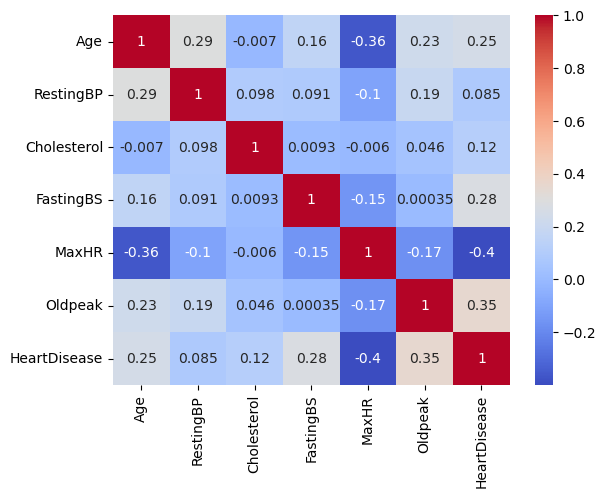

In [5]:
sns.heatmap(df_train.corr(numeric_only=True), cmap='coolwarm', annot=True)

<div class="alert alert-warning">

**Есть пропуски в графе**    
- возраст (Age) - 56 штук
- Тип боли в груди (ChestPainType) - 127 штук
- Артериальное давление в состоянии покоя (RestingBP) - 1 штука

In [6]:
df_train

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,74.0,M,NAP,138.0,NaN,0,Normal,116,N,0.2,Up,0
1,58.0,M,NAP,132.0,224.0,0,LVH,173,N,3.2,Up,1
2,44.0,M,ATA,150.0,288.0,0,Normal,150,Y,3.0,Flat,1
3,50.0,M,ASY,144.0,349.0,0,LVH,120,Y,1.0,Up,1
4,NaN,M,ASY,145.0,248.0,0,Normal,96,Y,2.0,Flat,1
...,...,...,...,...,...,...,...,...,...,...,...,...
584,58.0,M,ASY,115.0,NaN,1,Normal,138,N,0.5,Up,1
585,56.0,M,ASY,132.0,184.0,0,LVH,105,Y,2.1,Flat,1
586,52.0,M,ATA,134.0,201.0,0,Normal,158,N,0.8,Up,0
587,49.0,M,NAP,131.0,142.0,0,Normal,127,Y,1.5,Flat,1


In [7]:
df_train.isna().sum()

Age                56
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       127
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

Отделяем признаки от целевой переменной.

In [8]:
features_train = df_train.drop(['HeartDisease'], axis=1)
target_train = df_train['HeartDisease']

In [9]:
features_test = df_test.drop(['HeartDisease'], axis=1)
target_test = df_test['HeartDisease']

**Проверим сбалансированность классов**

In [10]:
target_train.value_counts()

1    381
0    208
Name: HeartDisease, dtype: int64

<div class="alert alert-warning">

**Все таки надо будет балансировать**

Переведем их в количественные

Но чтобы не надо было работать с пропусками в ручную, сделаем это автоматикой, чтобы упростить себе жизнь


In [11]:
class MyHeartDiseaseTransformer(TransformerMixin, BaseEstimator):
    '''Трансформер для предоработки данных перед предсказанием сердечной недостаточности у пациента.'''

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    
    def transform(self, X):
        X = pd.get_dummies(X, drop_first=True)
        X.fillna(X.mean(), inplace=True)
        X = X.reset_index(drop=True)
        return X

In [12]:
mhdt = MyHeartDiseaseTransformer()
mhdt.fit(features_train)
features_train_mhdt = mhdt.transform(features_train)
features_train_mhdt.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,74.000000,138.0,245.632035,0,116,0.2,1,0,1,0,1,0,0,0,1
1,58.000000,132.0,224.000000,0,173,3.2,1,0,1,0,0,0,0,0,1
2,44.000000,150.0,288.000000,0,150,3.0,1,1,0,0,1,0,1,1,0
3,50.000000,144.0,349.000000,0,120,1.0,1,0,0,0,0,0,1,0,1
4,54.195122,145.0,248.000000,0,96,2.0,1,0,0,0,1,0,1,1,0


<div class="alert alert-warning">

**Не лишним также будет отмаштабировать признаки. Все-таки мы не знаем досконально, в каких значениях мы работаем**

In [13]:
scaler = StandardScaler()
scaler.fit(features_train_mhdt)
features_train_mhdt_scaled = pd.DataFrame(scaler.transform(features_train_mhdt), columns=scaler.feature_names_in_)
features_train_mhdt_scaled.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,2.186049,0.246610,1.096468e-15,-0.589768,-0.758105,-0.689009,0.484563,-0.441278,2.008529,-0.223407,0.840979,-0.500531,-0.901281,-1.109532,1.276505
1,0.419980,-0.072203,-4.172660e-01,-0.589768,1.529085,2.113660,0.484563,-0.441278,2.008529,-0.223407,-1.189090,-0.500531,-0.901281,-1.109532,1.276505
2,-1.125331,0.884236,8.172468e-01,-0.589768,0.606184,1.926815,0.484563,2.266146,-0.497877,-0.223407,0.840979,-0.500531,1.109532,0.901281,-0.783389
3,-0.463055,0.565423,1.993892e+00,-0.589768,-0.597600,0.058369,0.484563,-0.441278,-0.497877,-0.223407,-1.189090,-0.500531,1.109532,-1.109532,1.276505
4,0.000000,0.618558,4.567631e-02,-0.589768,-1.560627,0.992592,0.484563,-0.441278,-0.497877,-0.223407,0.840979,-0.500531,1.109532,0.901281,-0.783389


Построим простой классификатор с помощью полученных признаков и оценим его качество

<div class="alert alert-warning">

Скорее всего модель переобучилась.
НО
Продолжим

<div class="alert alert-info">

* оберните весь конвейер преобразований в Pipeline

In [14]:
pipe = Pipeline([  
    ('transformer', MyHeartDiseaseTransformer()),
    ('scaler', StandardScaler()),
    ('classify', DecisionTreeClassifier(random_state=0, class_weight='balanced'))
])

Настраиваем трансформеры однократно на исходной обучающей выборке и проверяем, что они работают, как ожидается

In [15]:
pipe.fit(X=features_train, y=target_train)
print('Качество модели на обучающей выборке:', {roc_auc_score(target_train, pipe.predict_proba(features_train)[:, 1])})

Качество модели на обучающей выборке: {1.0}


In [16]:
print('Качество модели на тестовой выборке:', {roc_auc_score(target_test, pipe.predict_proba(features_test)[:, 1])})

Качество модели на тестовой выборке: {0.8305961754780653}


Очевидно модель переобучена

In [17]:
pipe['classify'].tree_.max_depth

15

**Переберем несколько вариантов алгоритмов (c разными значениями), с помощью кросс-валидации, чтобы улучшить качество на тестовой выборке**

**А именно:**
* Дерево решений (DecisionTreeClassifier)
* Логистическая регрессия (LogisticRegression)
* Классификатор опорный векторов (SVC)
* Наивный байесовский классификатор (GaussianNB)
* Cлучайный лес (RandomForestClassifier)
* Градиентный бустинг (XGBClassifier)

In [18]:
pipe = Pipeline([  
  ('transformer', MyHeartDiseaseTransformer()),
  ('scaler', StandardScaler()),
  ('classify', DecisionTreeClassifier(class_weight='balanced', random_state=0))
])

params = [
    {'classify': [LogisticRegression(class_weight='balanced', random_state=0)]}, 
    {'classify': [SVC(class_weight='balanced',  random_state=0)]},
    {'classify': [GaussianNB()]},
    {'classify': [RandomForestClassifier(class_weight='balanced', random_state=0)], 'classify__max_depth': [2, 5, 10, 20],
                                                                                    'classify__n_estimators': [2, 4, 6, 8],
                                                                                    'classify__min_samples_split': [2, 4, 8, 10],
                                                                                    'classify__min_samples_leaf': [1, 2, 4, 6]},
    
    {'classify': [DecisionTreeClassifier(class_weight='balanced', random_state=0)], 'classify__max_depth': [2, 5, 10, 20]},
    {'classify': [XGBClassifier(random_state=0)], 'classify__max_depth': [2, 4, 6, 8], 
                                                  'classify__n_estimators': [2, 5, 10, 20]}
]

grid_search = GridSearchCV(pipe, param_grid=params, cv=5, scoring='roc_auc')
grid_search.fit(X=features_train, y=target_train)
print(
    'Качество модели на тестовой выборке c лучшей моделью:', 
    {roc_auc_score(target_test, grid_search.predict_proba(features_test)[:, 1])}
)

Качество модели на тестовой выборке c лучшей моделью: {0.9124859392575928}


In [19]:
grid_search.best_estimator_

Pipeline(steps=[('transformer', MyHeartDiseaseTransformer()),
                ('scaler', StandardScaler()),
                ('classify',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=20,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=0, ...))])

In [20]:
pd.DataFrame.from_dict(grid_search.cv_results_).transpose()

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
mean_fit_time,0.021806,0.020085,0.013606,0.022394,0.021837,0.024415,0.032677,0.029443,0.02461,0.034451,...,0.025807,0.029202,0.022,0.02392,0.026794,0.033505,0.023345,0.026204,0.030112,0.035116
std_fit_time,0.007226,0.001184,0.002778,0.007462,0.002756,0.003948,0.005006,0.008993,0.006899,0.010084,...,0.000932,0.00075,0.00083,0.000512,0.000848,0.000999,0.000737,0.001567,0.002271,0.001212
mean_score_time,0.01261,0.015406,0.01297,0.016114,0.012216,0.013396,0.01744,0.018612,0.013861,0.018635,...,0.018972,0.018203,0.018545,0.018302,0.018603,0.019201,0.019101,0.019934,0.019799,0.019412
std_score_time,0.001464,0.0014,0.002507,0.005194,0.00095,0.002599,0.005556,0.006621,0.002338,0.005728,...,0.001101,0.000249,0.000665,0.00087,0.000805,0.000679,0.001495,0.001618,0.001326,0.000594
param_classify,"LogisticRegression(class_weight='balanced', ra...","SVC(class_weight='balanced', random_state=0)",GaussianNB(),RandomForestClassifier(class_weight='balanced'...,RandomForestClassifier(class_weight='balanced'...,RandomForestClassifier(class_weight='balanced'...,RandomForestClassifier(class_weight='balanced'...,RandomForestClassifier(class_weight='balanced'...,RandomForestClassifier(class_weight='balanced'...,RandomForestClassifier(class_weight='balanced'...,...,"XGBClassifier(base_score=None, booster=None, c...","XGBClassifier(base_score=None, booster=None, c...","XGBClassifier(base_score=None, booster=None, c...","XGBClassifier(base_score=None, booster=None, c...","XGBClassifier(base_score=None, booster=None, c...","XGBClassifier(base_score=None, booster=None, c...","XGBClassifier(base_score=None, booster=None, c...","XGBClassifier(base_score=None, booster=None, c...","XGBClassifier(base_score=None, booster=None, c...","XGBClassifier(base_score=None, booster=None, c..."
param_classify__max_depth,NaN,NaN,NaN,2,2,2,2,2,2,2,...,4,4,6,6,6,6,8,8,8,8
param_classify__min_samples_leaf,NaN,NaN,NaN,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
param_classify__min_samples_split,NaN,NaN,NaN,2,2,2,2,4,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
param_classify__n_estimators,NaN,NaN,NaN,2,4,6,8,2,4,6,...,10,20,2,5,10,20,2,5,10,20
params,{'classify': LogisticRegression(class_weight='...,"{'classify': SVC(class_weight='balanced', rand...",{'classify': GaussianNB()},{'classify': RandomForestClassifier(class_weig...,{'classify': RandomForestClassifier(class_weig...,{'classify': RandomForestClassifier(class_weig...,{'classify': RandomForestClassifier(class_weig...,{'classify': RandomForestClassifier(class_weig...,{'classify': RandomForestClassifier(class_weig...,{'classify': RandomForestClassifier(class_weig...,...,"{'classify': XGBClassifier(base_score=None, bo...","{'classify': XGBClassifier(base_score=None, bo...","{'classify': XGBClassifier(base_score=None, bo...","{'classify': XGBClassifier(base_score=None, bo...","{'classify': XGBClassifier(base_score=None, bo...","{'classify': XGBClassifier(base_score=None, bo...","{'classify': XGBClassifier(base_score=None, bo...","{'classify': XGBClassifier(base_score=None, bo...","{'classify': XGBClassifier(base_score=None, bo...","{'classify': XGBClassifier(base_score=None, bo..."


<div class="alert alert-success">

# Вывод:
**Самым лучшим алгоритмом оказался XGBClassifier (Градиентный бустинг), а именно 20 деревьев с максимальной глубиной дерева 2.**